# Analiza danych z pyszne.pl (dla Warszawa-Centrum)

### Analiza dotyczy ok. 520 restauracji

Autor: <a href="https://www.linkedin.com/in/marianwitkowski/" target="_top">Marian Witkowski</a>

In [1]:
import pandas as pd
import bs4
import requests
import matplotlib.pyplot as plt
import ast 

%matplotlib inline

## Scraping danych z pyszne.pl

In [2]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:72.0) Gecko/20100101 Firefox/72.0',
}
url = "https://www.pyszne.pl/restauracja-warszawa-srodmiescie-00-120"
result = requests.get(url, headers=headers)

## Pobranie informacji o lokalizacji punktów

In [3]:
"""
 Koordynaty GPS punktów znajdują się w tablicy JavaScipt w kodzie strony
"""
ix = result.text.find('restaurants =')
s = result.text[ix+len('restaurants ='):]
ix = s.find("];")
s = s[:ix+1]

geo = []

for line in s.split("\n"):
    line = line.strip()
    if line:
        items=line.split(",")
        for index,item in enumerate(items):
            if item.startswith('52.'):
                restaurant = {"_id": items[0].replace("[","").replace("'",""), "lat":item, "lng":items[index+1] }
                geo.append(restaurant)

df_geo = pd.DataFrame(geo)
df_geo.head()

,_id,lat,lng
0,51NRR73,52.2068244,21.019619
1,51QRR73,52.22373,21.009568
2,57O00Q3,52.2259398,21.0084917
3,50530Q3,52.2345152,21.0335755
4,51730Q3,52.234708,21.0331829


In [4]:
restaurants = list()

html_data = bs4.BeautifulSoup(result.text, features='lxml')
items = html_data.find_all('div', class_='js-restaurant')
for item in items:

    _id = str(item.attrs["id"]).replace("irestaurant","")

    title =  item.find('a', class_='restaurantname').text.strip()
    kitchens = item.find('div', class_='kitchens').text.strip()

    try:
        deliv_cost = item.find('div', class_='js-delivery-cost').text.strip()
    except:
        deliv_cost = "???"

    try:
        deliv_time = item.find('div', class_='avgdeliverytimefull').text.strip()
    except:
        deliv_time = "???"

    try:
        min_order = item.find('div', class_='min-order').text.strip()
    except:
        min_order = "???"

    restaurants.append({"_id" : _id, "title":title, "kitchens":kitchens, 
                         "deliv_time":deliv_time, "deliv_cost":deliv_cost, "min_order":min_order})
    print(".", end='')

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

## Utworzenie data frame

In [5]:
df = pd.DataFrame(restaurants)
df.replace("???", pd.np.NaN, inplace=True)
df.dropna(axis='rows', thresh=4, inplace=True)

## Konwersja i modyfikcja danych

In [6]:
def conv_deliv_time(s):
    if s.startswith("Od"):
        return s.replace("Od","").strip()
    if s.startswith("ok."):
        return s.replace("ok.","").strip()
    return s
    
df.deliv_time = df.deliv_time.apply(conv_deliv_time)

In [7]:
df.insert(3, 'is_open', df.deliv_time.apply(lambda s: s.endswith('min')) )

In [8]:
df.deliv_cost = df.deliv_cost.apply(lambda s: 
                    s.replace("GRATIS","0").replace("zł","").replace(",",".").strip() ).astype('float')

In [9]:
df.min_order = df.min_order.apply(lambda s:
                   str(s).replace("zł","").replace("Min.","").\
                   replace(",",".").replace("nan","0").strip()).astype('float')

In [10]:
df = pd.merge(df, df_geo, on='_id')
df

,_id,title,kitchens,is_open,deliv_time,deliv_cost,min_order,lat,lng
0,51NRR73,Sushi Box,"Sushi, Japońska, Zupy",True,45min,0.0,75.0,52.2068244,21.019619
1,51QRR73,Pizzeria Napoli,"Włoska, Makarony, Pizza",True,50min,5.0,25.0,52.22373,21.009568
2,57O00Q3,Restauracja Katmandu,"Tajska, Wegetariańska, Indyjska",True,65min,0.0,40.0,52.2259398,21.0084917
3,50530Q3,Da Grasso,"Dania na lunch, Makarony, Pizza",True,65min,5.5,23.0,52.2345152,21.0335755
4,51730Q3,Grande Pierogi,"Polska, Pierogi, Zupy",False,Zamknięte,0.0,25.0,52.234708,21.0331829
...,...,...,...,...,...,...,...,...,...
514,O7PN0NN1,Sana Sushi Nocą,"Sushi, Japońska",False,16:00,10.0,50.0,52.1429226,21.0351436
515,O1131NN1,Fenicja - Restauracja Libańska i Kebab,"Zupy, Arabska, Falafel",True,75min,0.0,25.0,52.2344441,21.0031145
516,O0351NN1,Sensi Sushi Ochota,"Sushi, Japońska, Zupy",True,50min,0.0,90.0,52.2045424,20.9700819
517,O0Q73NN1,Foodie Rollins,"Kanapki, Burgery, Międzynarodowa",False,Zamknięte,0.0,30.0,52.2186881,21.0173445


## Rodzaje kuchni - One-hot encoding

In [11]:
kitchen_list = []
def convert_kitchens(s):
    items = s.split(",")
    row = {}
    for item in items:
        row[item.strip()]=True
    kitchen_list.append(row)
    return s

df.kitchens.apply(convert_kitchens)
df_kitchens = pd.DataFrame(kitchen_list) 
df_kitchens

,Sushi,Japońska,Zupy,Włoska,Makarony,Pizza,Tajska,Wegetariańska,Indyjska,Dania na lunch,...,Francuska,Wieprzowina,Curry,Grecka,Desery,Ryby,Gyros,Koreańska,Menu dla dzieci,Cielęcina
0,True,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,True,True,True,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
515,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
516,True,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Średni czas dostawy

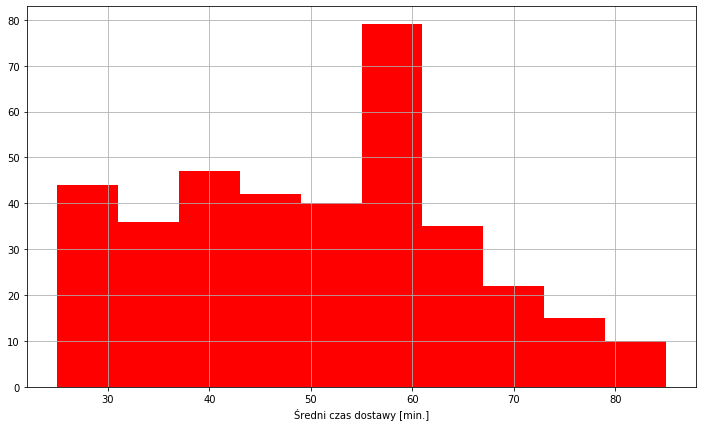

In [12]:
df[df.is_open==True].deliv_time.str.replace('min','').astype('int').hist(bins=10, figsize=(12,7), color='red')
plt.xlabel('Średni czas dostawy [min.]')
plt.show()

## Koszt dostawy

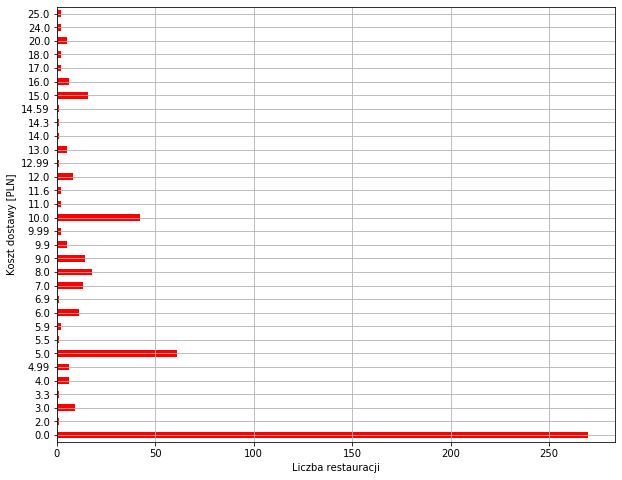

In [13]:
df.deliv_cost.value_counts().sort_index().plot(kind='barh', figsize=(10,8), grid=True, color='red')
plt.xlabel('Liczba restauracji')
plt.ylabel('Koszt dostawy [PLN]')
plt.show()

## Min. kwota zamówienia

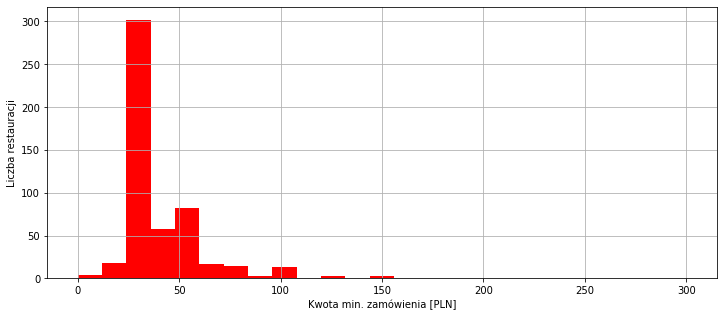

In [14]:
df.min_order.hist(bins=25, figsize=(12,5), color='red')
plt.xlabel('Kwota min. zamówienia [PLN]')
plt.ylabel('Liczba restauracji')
plt.show()

## Dostępność rodzajów kuchni

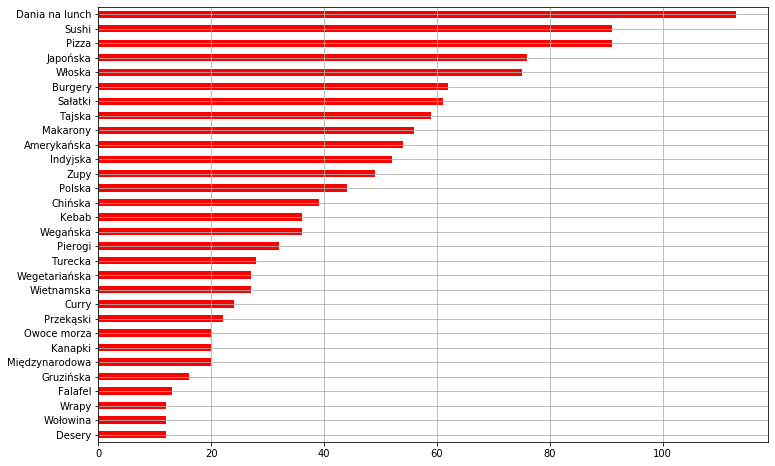

In [15]:
df_tmp = df_kitchens.sum().nlargest(30).to_frame().iloc[::-1]
df_tmp.plot(kind='barh', figsize=(12,8), color='red', legend=False, grid=True)
plt.show()